In [1]:
# uncomment this if you want to use interactive plot (only works in Jupyter not works in VScode)
# %matplotlib widget

import scanpy as sc
import numpy as np
import pandas as pd

import scSLAT
from scSLAT.model import Cal_Spatial_Net, load_anndatas, run_SLAT, spatial_match
from scSLAT.viz import match_3D_multi, hist, Sankey
from scSLAT.metrics import region_statistics

In [2]:
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=150, frameon=True, vector_friendly=True, fontsize=14)

In [3]:
adata1 = sc.read_h5ad(r"D:\ppppaper\SLAT\SLAT-main\SLAT-main\data\Chen-Stereo_seq-E15.5-s1.h5ad")
adata2 = sc.read_h5ad(r"D:\ppppaper\SLAT\SLAT-main\SLAT-main\data\Chen-Stereo_seq-E15.5-s2.h5ad")

In [4]:
adata1

AnnData object with n_obs × n_vars = 6000 × 28798
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'annotation', 'Regulon - AI987944', 'Brain_shapes', 'Face_shapes', 'Heart_shapes', 'Lung_shapes', 'Liver_shapes', 'Shapes_shapes', 'Belly_shapes', 'Back_shapes', 'region'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'region_colors'
    obsm: 'spatial', 'spatial_back'
    varm: 'PCs'

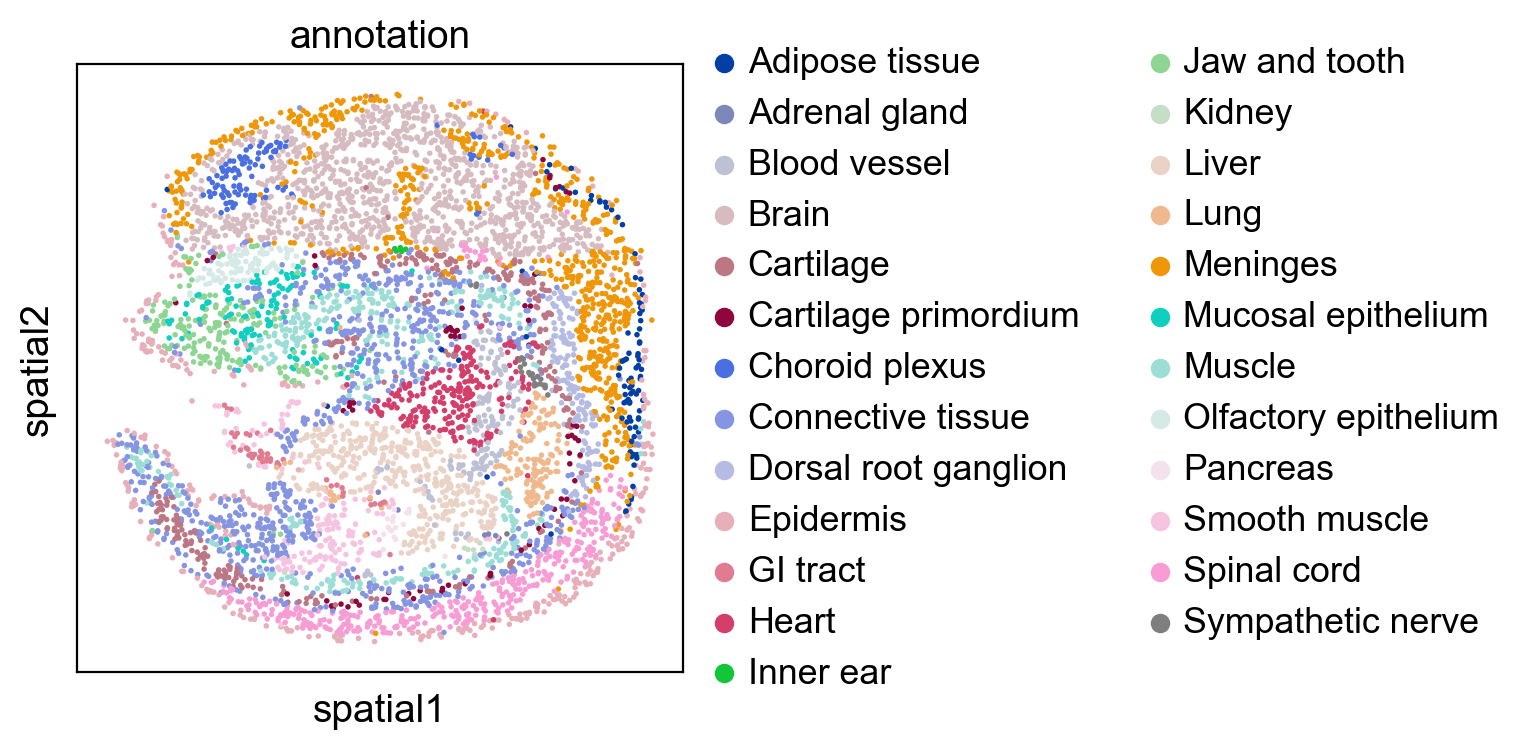

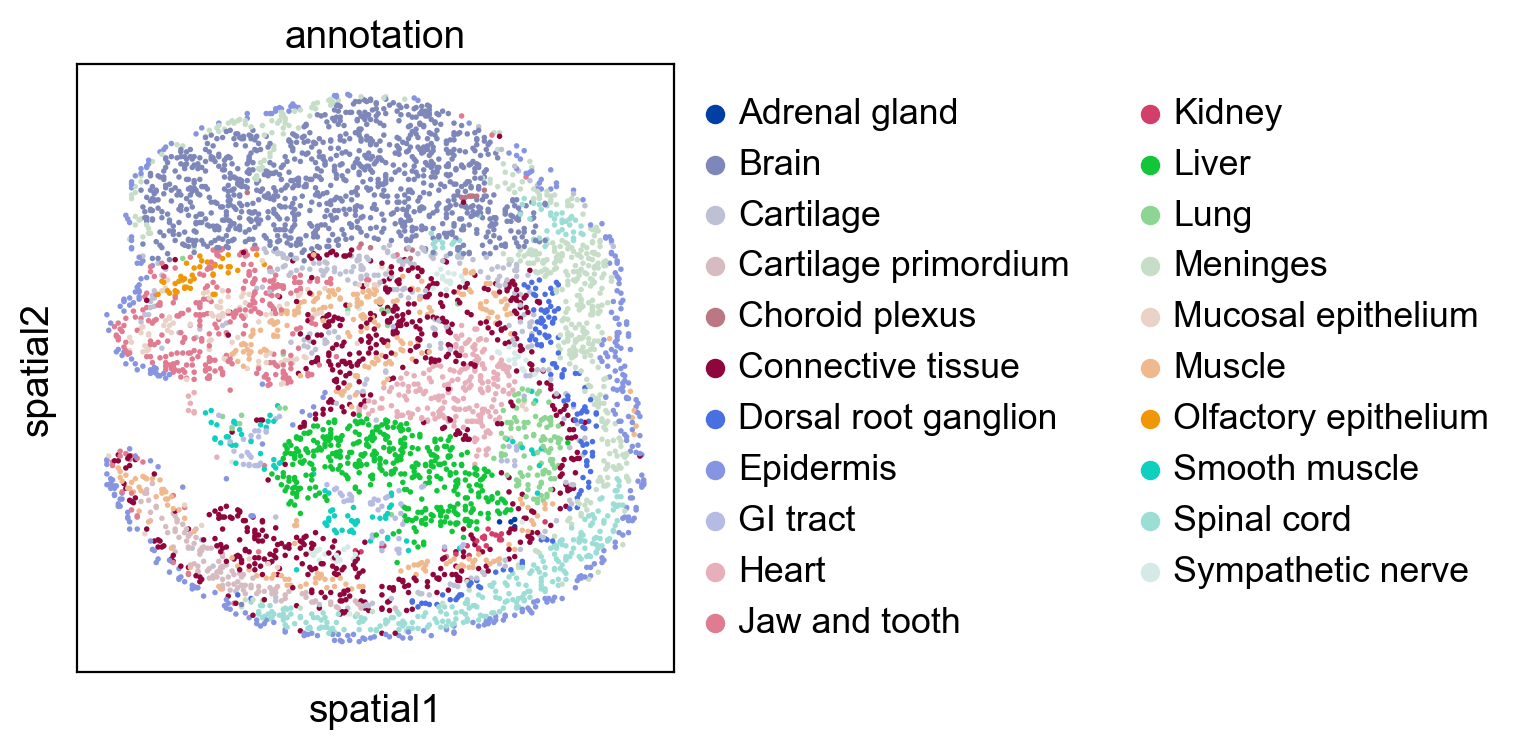

In [5]:
sc.pl.spatial(adata1, color="annotation", spot_size=10)
sc.pl.spatial(adata2, color="annotation", spot_size=10)

In [6]:
Cal_Spatial_Net(adata1, k_cutoff=10, model='KNN')
Cal_Spatial_Net(adata2, k_cutoff=10, model='KNN')

Calculating spatial neighbor graph ...
The graph contains 68008 edges, 6000 cells.
11.334666666666667 neighbors per cell on average.
Calculating spatial neighbor graph ...
The graph contains 56646 edges, 5000 cells.
11.3292 neighbors per cell on average.


In [7]:
edges, features = load_anndatas([adata1, adata2], feature='DPCA')

Use DPCA feature to format graph


d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\preprocessing\_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [8]:
embd0, embd1, time = run_SLAT(features, edges)

GPU is not available
Running
---------- epochs: 1 ----------
---------- epochs: 2 ----------
---------- epochs: 3 ----------
---------- epochs: 4 ----------
---------- epochs: 5 ----------
---------- epochs: 6 ----------
Training model time: 46.17


In [9]:
best, index, distance = spatial_match(features, adatas=[adata1,adata2], reorder=False)

In [10]:
adata1_df = pd.DataFrame({'index': range(embd0.shape[0]),
                        'x': adata1.obsm['spatial'][:,0],
                        'y': adata1.obsm['spatial'][:,1],
                        'celltype': adata1.obs['annotation']})
adata2_df = pd.DataFrame({'index': range(embd1.shape[0]),
                        'x': adata2.obsm['spatial'][:,0],
                        'y': adata2.obsm['spatial'][:,1],
                        'celltype': adata2.obs['annotation']})

matching = np.array([range(index.shape[0]), best])
best_match = distance[:,0]

In [11]:
matching

array([[   0,    1,    2, ..., 4997, 4998, 4999],
       [2595, 1059,  220, ..., 2002, 3948, 3095]], dtype=int64)

dataset1: 25 cell types; dataset2: 21 cell types; 
                    Total :25 celltypes; Overlap: 21 cell types 
                    Not overlap :[['Pancreas', 'Adipose tissue', 'Inner ear', 'Blood vessel']]
Subsampled 300 pairs from 5000


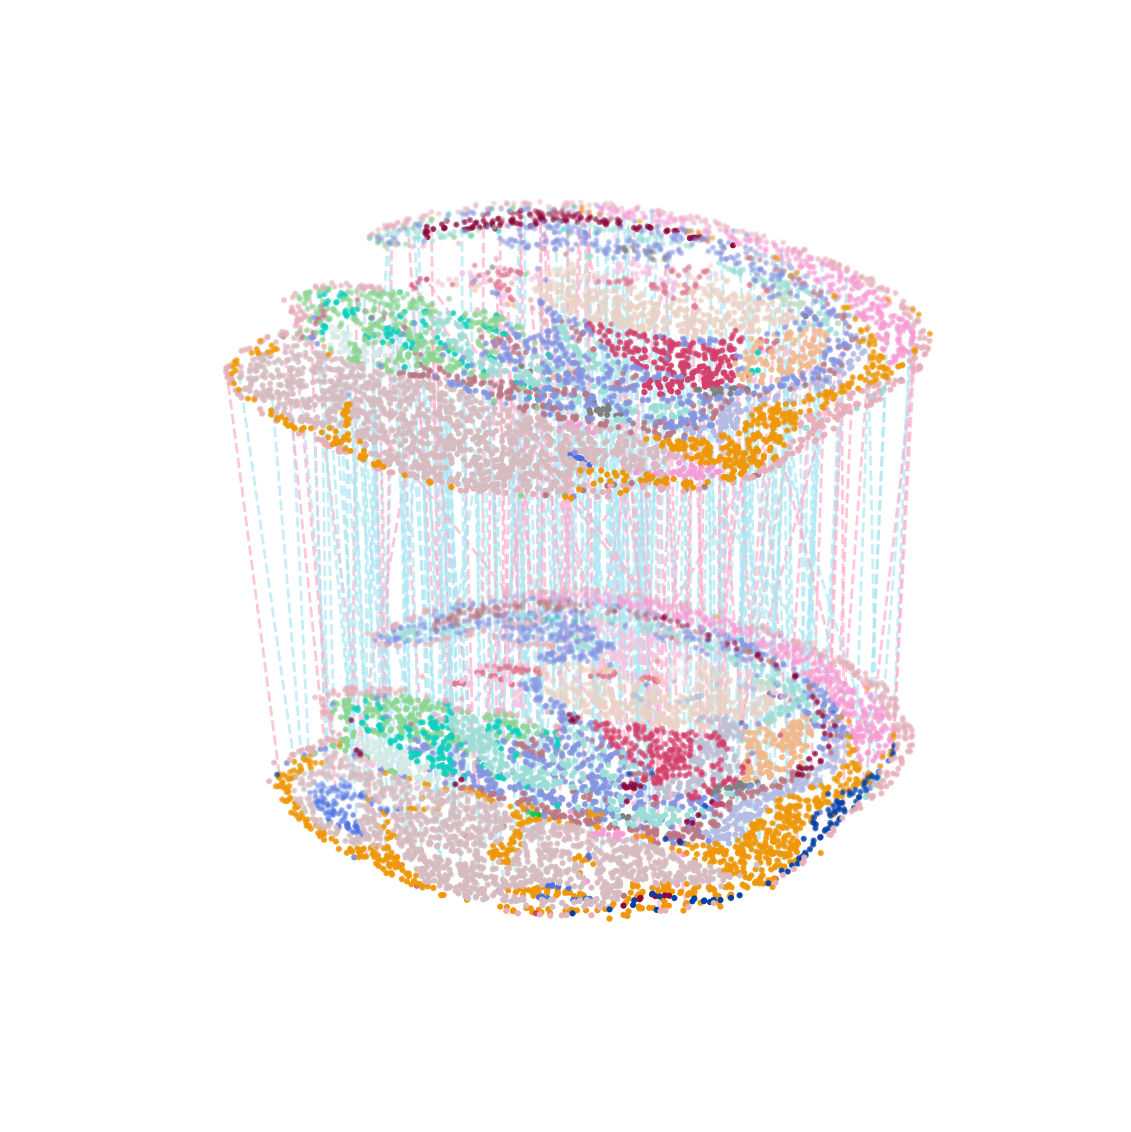

In [12]:
multi_align = match_3D_multi(adata1_df, adata2_df, matching,meta='celltype',
                            scale_coordinate=True, subsample_size=300)
multi_align.draw_3D(size=[7, 8], line_width=1, point_size=[1.5,1.5], hide_axis=True)

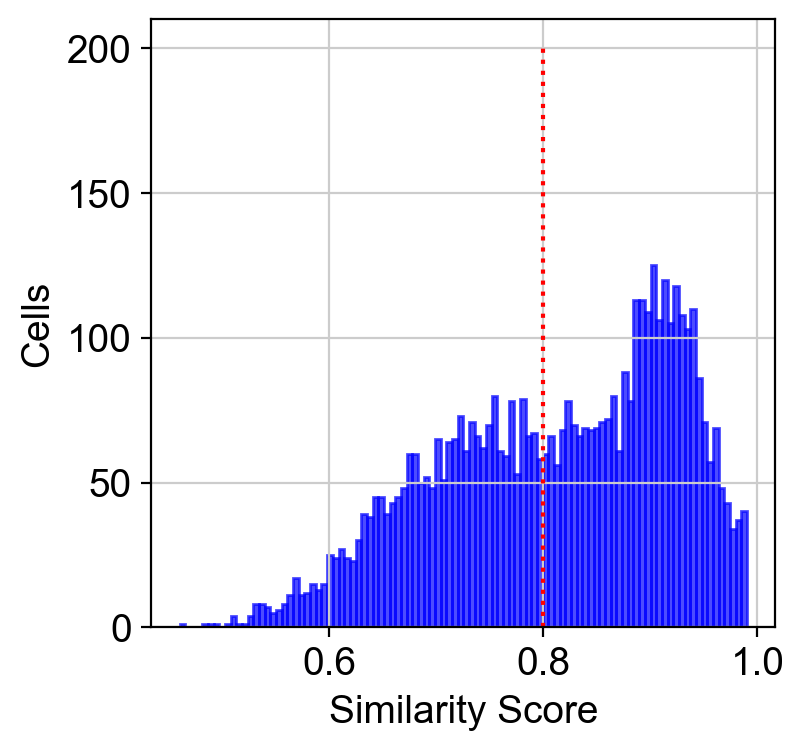

In [13]:
%matplotlib inline
hist(best_match, cut=0.8)

In [14]:
adata2.obs['low_quality_index'] = best_match
adata2.obs['low_quality_index'] = adata2.obs['low_quality_index'].astype(float)

In [15]:
adata1.obsm['scSLAT'] = embd0.detach().cpu().numpy()
adata2.obsm['scSLAT'] = embd1.detach().cpu().numpy()

adata_com=sc.concat([adata1,adata2], label= 'slice_name', keys= ['slice_1','slice_2'])

sc.pp.neighbors(adata_com, use_rep= 'scSLAT')
sc.tl.umap(adata_com,)

d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
d:\Anaconda\envs\scSLAT\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


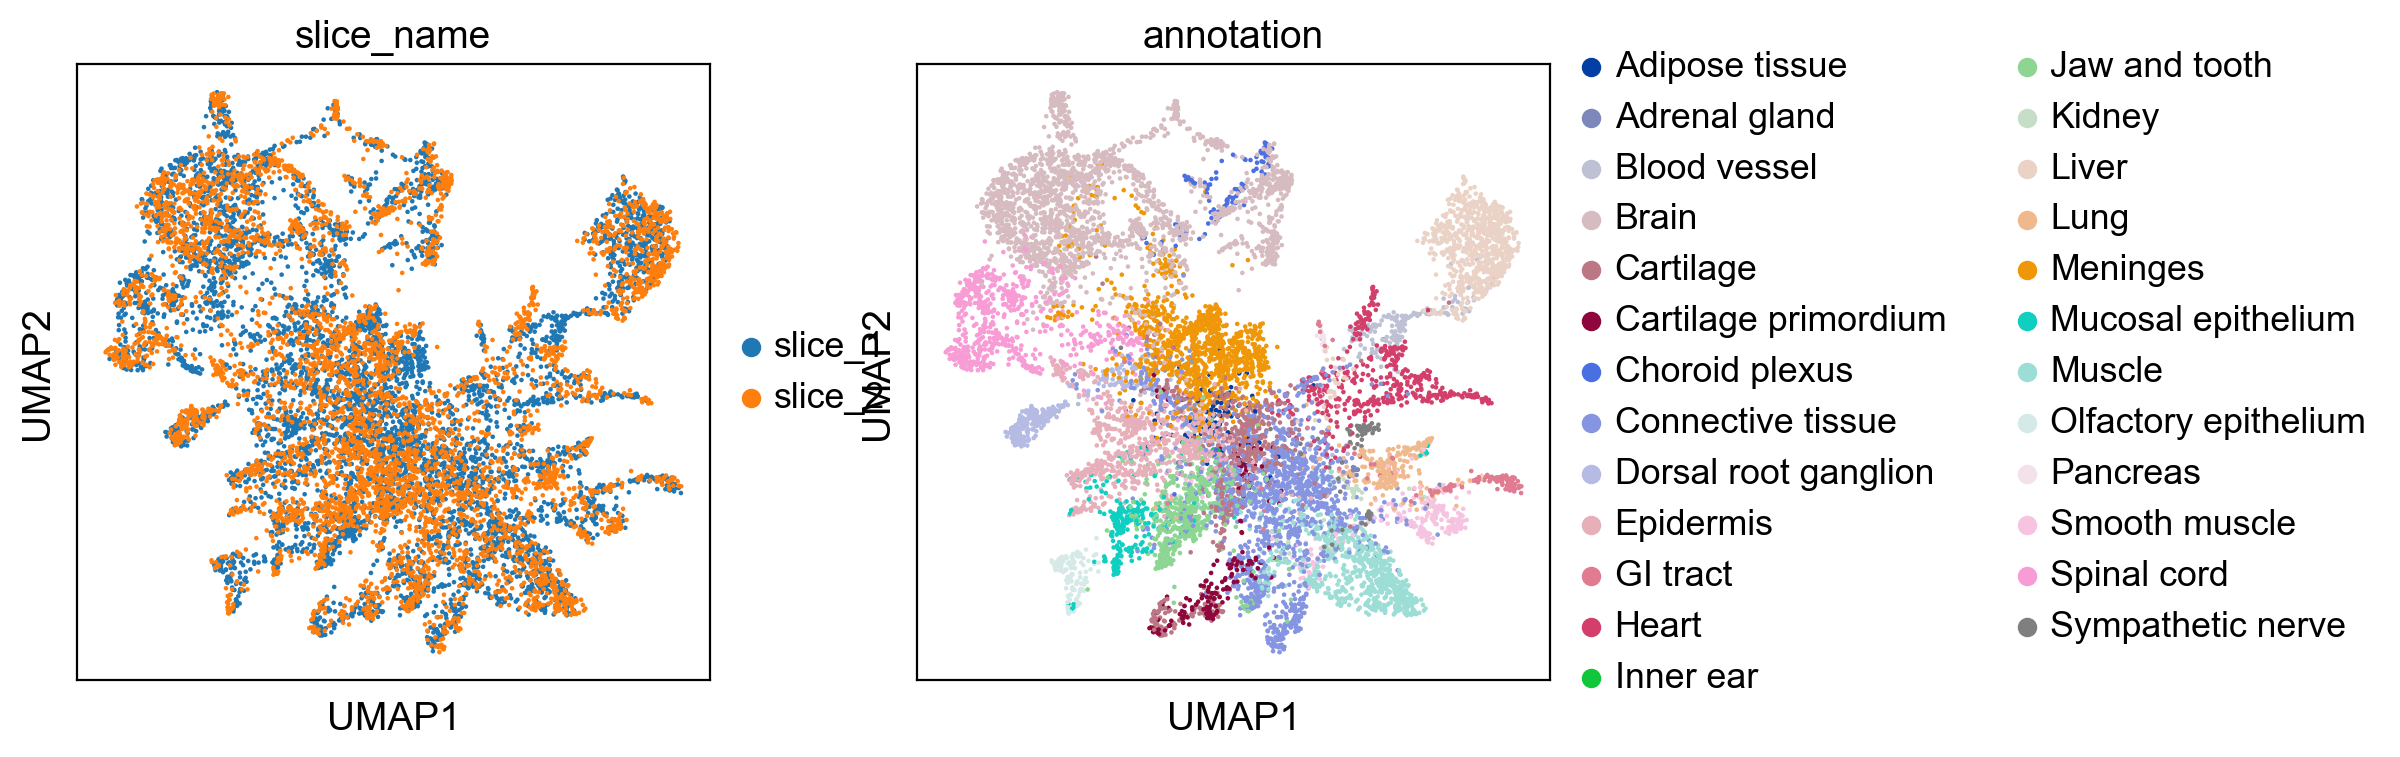

In [16]:
sc.pl.umap(adata_com, color= ['slice_name','annotation'])

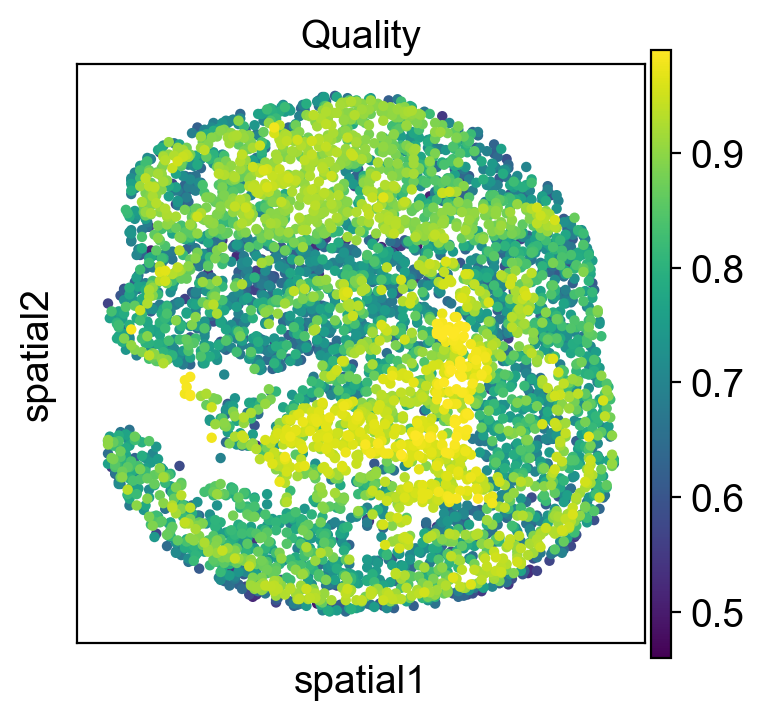

In [17]:
sc.pl.spatial(adata2, color='low_quality_index', spot_size=20, title='Quality')

In [18]:
adata2_df['target_celltype'] = adata1_df.iloc[matching[1,:],:]['celltype'].to_list()
matching_table = adata2_df.groupby(['celltype','target_celltype']).size().unstack(fill_value=0)

In [19]:
matching_table

target_celltype,Adipose tissue,Adrenal gland,Blood vessel,Brain,Cartilage,Cartilage primordium,Choroid plexus,Connective tissue,Dorsal root ganglion,Epidermis,...,Liver,Lung,Meninges,Mucosal epithelium,Muscle,Olfactory epithelium,Pancreas,Smooth muscle,Spinal cord,Sympathetic nerve
celltype,,,,,,,,,,,,,,,,,,,,,
Adrenal gland,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
Brain,0,0,0,933,1,0,61,7,0,1,...,0,0,44,0,0,1,0,0,4,0
Cartilage,10,0,34,0,57,44,1,59,0,0,...,1,0,7,0,2,0,0,0,0,1
Cartilage primordium,0,0,0,0,78,5,0,30,0,0,...,0,0,0,0,0,0,0,0,0,0
Choroid plexus,0,0,0,1,2,0,1,1,0,0,...,0,0,6,1,0,0,0,0,0,0
Connective tissue,14,1,15,1,12,14,0,369,8,4,...,1,10,7,4,68,0,0,32,2,4
Dorsal root ganglion,0,0,0,0,0,0,0,0,123,0,...,0,0,0,0,0,0,0,0,1,0
Epidermis,66,0,6,0,4,6,0,23,0,180,...,1,1,53,0,0,0,0,0,35,1
GI tract,0,0,2,0,0,0,0,2,0,0,...,1,13,0,2,0,0,9,12,0,0


In [20]:
Sankey(matching_table, prefix=['E15.5_E1S1','E15.5_E1S2'])

In [21]:
correct_matches = 0
total_matches = 0

# 遍历 matching_table 并累加匹配数目
for i, row in matching_table.iterrows():
    # 检查行索引和列索引是否相同，如果是，则累加该单元格的值到正确匹配计数器中
    if i in matching_table.columns and row[i] > 0:
        correct_matches += row[i]
        
    # 累加所有单元格的值，得到所有匹配的总数
    total_matches += row.sum()

# 计算匹配准确度
accuracy = correct_matches / total_matches if total_matches > 0 else 0

correct_matches,total_matches,accuracy

(3485, 5000, 0.697)